## Function derivative

In [359]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
def function(x):
    return 3*x**2 - 2*x + 1

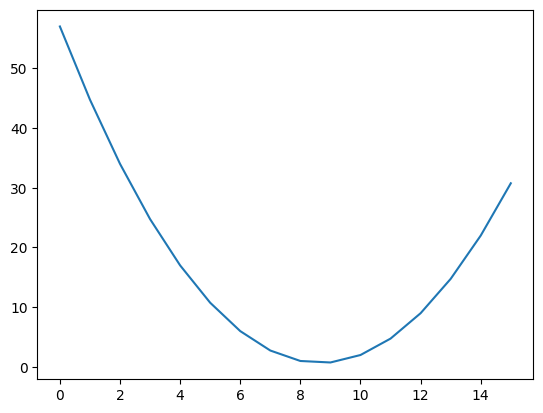

In [3]:
ys = []
for x in np.arange(-4, 4, 0.5):
    ys.append(function(x))

plt.plot(ys)

In [4]:
def function_derviative(f, x, h):
    return (f(x + h) - f(x))/h

In [5]:
x = 2

# Function value at x = 2
function(x)

# Function derivative
print('Function derivative calculated:', function_derviative(function, 2, h = 0.00001))
print('Function derivative actual:', 6*x - 2)

Function derivative calculated: 10.000030000156812
Function derivative actual: 10


## Value class

In [391]:
class Value:

    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self.grad = 0.0
        self._prev = _children
        self._op = _op
        self.label = label
        self._backward = lambda: None

    def __repr__(self):
        return f'Value(data={self.data})'

    def __add__(self, right_operand):
        right_operand = right_operand if isinstance(right_operand, Value) else Value(data = right_operand)
        out = Value(self.data + right_operand.data, (self, right_operand), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            right_operand.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __radd__(self, right_operand):
        out = self + right_operand
        return out

    def __sub__(self, right_operand):
        out = self + (-right_operand)
        return out

    def __mul__(self, right_operand):
        right_operand = right_operand if isinstance(right_operand, Value) else Value(data = right_operand)
        out = Value(self.data * right_operand.data, (self, right_operand), '*')

        def _backward():
            self.grad += right_operand.data * out.grad
            right_operand.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, right_operand):
        out = self * right_operand
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad = other * self.data ** (other - 1) * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        out = Value((math.exp(2*x) - 1)/(math.exp(2*x) + 1), (self,), 'tanh')

        def _backward():
            self.grad += (1 - out.data**2) * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
          node._backward()

In [39]:
a = Value(2.0)
b = Value(10.0)
c = Value(3.0)

print('a + 5.0:', a + 5.0)
print('5.0 + a:', 5.0 + a)
print('a + b + c:', a + b + c)
print('-' * 10)
print('a * 5.0:', a * 5.0)
print('5.0 * a:', 5.0 * a)
print('a * b * c:', a * b * c)

a + 5.0: Value(data=7.0)
5.0 + a: Value(data=7.0)
a + b + c: Value(data=15.0)
----------
a * 5.0: Value(data=10.0)
5.0 * a: Value(data=10.0)
a * b * c: Value(data=60.0)


In [40]:
d = a + b
d._prev, d._op

((Value(data=2.0), Value(data=10.0)), '+')

In [258]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

## Visualisation

In [259]:
import graphviz

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = graphviz.Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = '{%s | data %.4f | grad %.4f}' % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

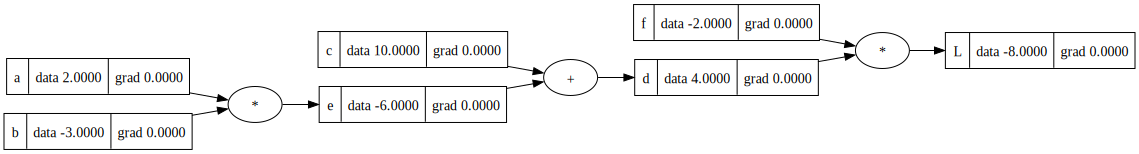

In [260]:
draw_dot(L)

In [88]:
L.grad = 1.0

## Manual gradient calculation

In [186]:
def L_derviative():
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'

    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    Lh = d * f; Lh.label = 'Lh'

    return (Lh.data - L.data)/h

In [187]:
L.grad = 1

In [212]:
dL_dL = 1
print('L grad calculated:', L.grad)
print('L grad actual:', dL_dL)
print()

dL_df = d.data
print('f grad calculated:', f.grad)
print('f grad actual:', dL_df)
print()

dL_dd = f.data
print('d grad calculated:', d.grad)
print('d grad actual:', dL_dd)
print()

dd_dc = 1.0
dL_dc = dL_dd * dd_dc
print('c grad calculated:', c.grad)
print('c grad actual:', dL_dc)
print()

dd_de = 1.0
dL_de = dL_dd * dd_de
print('e grad calculated:', e.grad)
print('e grad actual:', dL_de)
print()

de_db = a.data
dL_db = dL_de * de_db
print('b grad calculated:', b.grad)
print('b grad actual:', dL_db)
print()

de_da = b.data
dL_da = dL_de * de_da
print('a grad calcualted:', a.grad)
print('a grad actual:', dL_da)

L grad calculated: 0.0
L grad actual: 1

f grad calculated: 0.0
f grad actual: 4.0

d grad calculated: 0.0
d grad actual: -2.0

c grad calculated: 0.0
c grad actual: -2.0

e grad calculated: 0.0
e grad actual: -2.0

b grad calculated: 0.0
b grad actual: -4.0

a grad calcualted: 0.0
a grad actual: 6.0


In [229]:
L.grad = 1
f.grad = dL_df
d.grad = dL_dd
c.grad = dL_dc
e.grad = dL_de
b.grad = dL_db
a.grad = dL_da

## Optimization step

In [230]:
# move in the direction of gradient to increase the target & in opposite direction to decrease the target
a.data -= (0.001 * a.grad)
b.data -= (0.001 * b.grad)
c.data -= (0.001 * c.grad)
f.data -= (0.001 * f.grad)
print('L before:', L.data)

e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
L = d * f; L.label = 'L'
print('L after:', L.data)

L before: -8.360857952000003
L after: -8.433395712000006


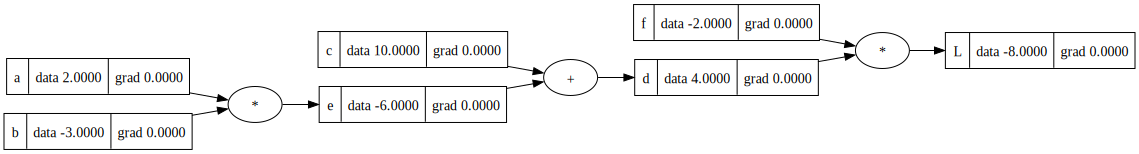

In [261]:
draw_dot(L)

In [263]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

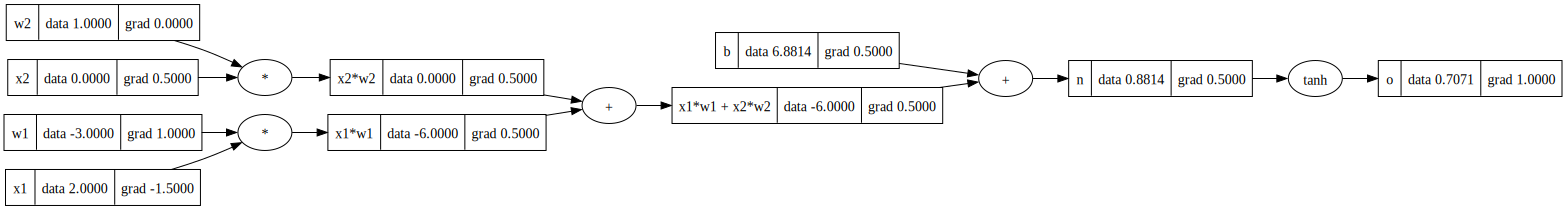

In [273]:
draw_dot(o)

In [272]:
w1.grad = x1.data * x1w1.grad
x1.grad = w1.data * x1w1.grad

In [270]:
w2.grad = x2.data * x2w2.grad
x2.grad = w2.data * x2w2.grad

In [265]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [266]:
b.grad = 0.5
x1w1x2w2.grad = 0.5

In [267]:
o.grad = 1

In [268]:
do_dn = 1 - (o.data**2)
n.grad = do_dn

In [319]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

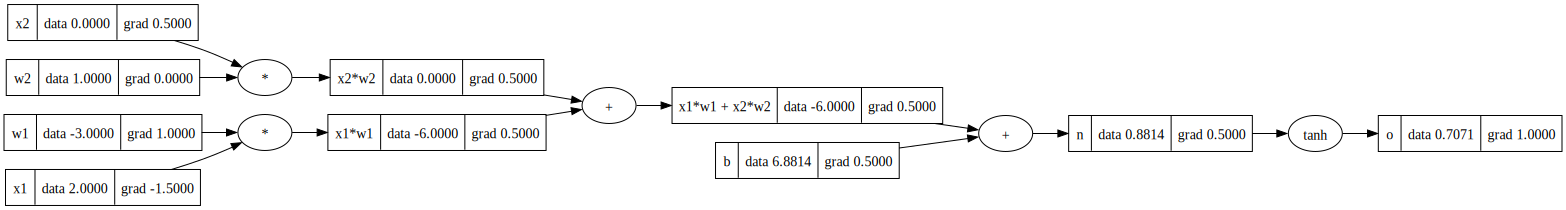

In [332]:
draw_dot(o)

In [321]:
o.grad = 1

In [323]:
o._backward()

In [325]:
n._backward()

In [327]:
x1w1x2w2._backward()

In [329]:
x2w2._backward()

In [331]:
x1w1._backward()

In [337]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

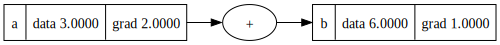

In [339]:
a = Value(3.0, label='a')
b = a + a ; b.label = 'b'
b.backward()
draw_dot(b)

In [340]:
import torch

In [341]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


## Neural Network

In [408]:
class Neuron:
    def __init__(self, n_inps):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(n_inps)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((w_* x_ for w_, x_ in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

In [432]:
class Layer:
    def __init__(self, n_inps, n_outs):
        self.neurons = [Neuron(n_inps) for _ in range(n_outs)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        params = []
        for n in self.neurons:
            params.extend(n.parameters())
        return params

In [433]:
class MLP:
    def __init__(self, n_layers):
        self.layers = [Layer(n_layers[i], n_layers[i + 1]) for i in range(len(n_layers) - 1)]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        params = []
        for l in self.layers:
            params.extend(l.parameters()) 
        return params

In [434]:
x = [2.0, 3.0, -1.0]
n = MLP([3, 4, 4, 1])
out = n(x)

In [397]:
out

Value(data=0.8320022600675457)

In [398]:
out.backward()

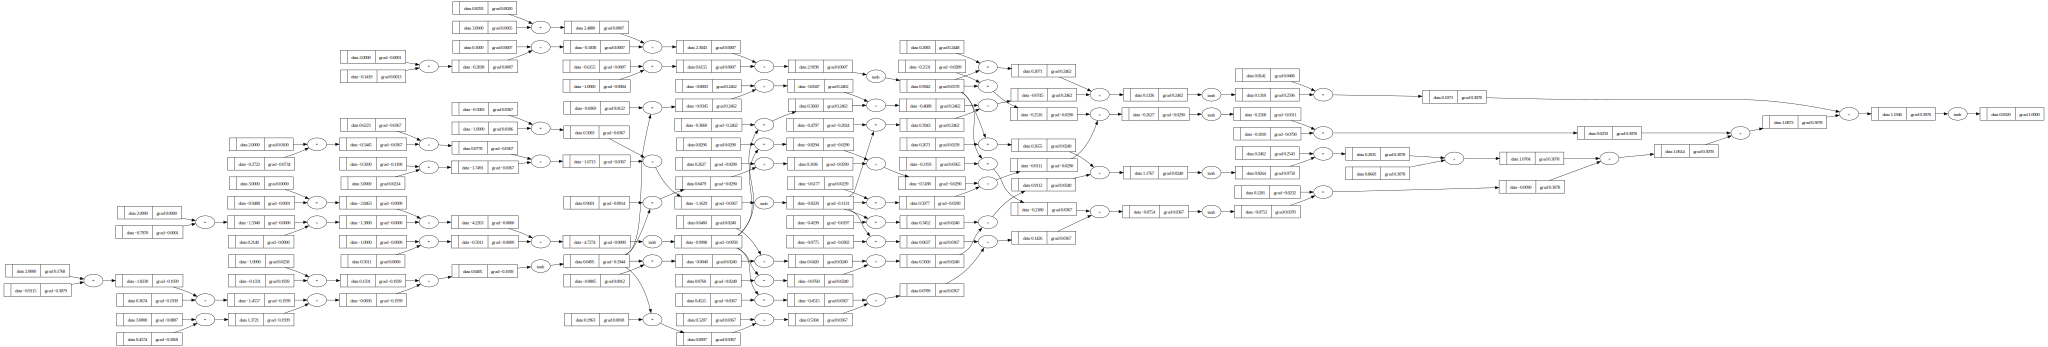

In [399]:
draw_dot(out)

In [414]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [436]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 4.6218153823724855
1 1.2274970311415547
2 1.1001458524061678
3 2.0144679616377332
4 0.30482154491158797
5 0.019748072932817023
6 0.01808777993869211
7 0.016691176700646838
8 0.015498931456418804
9 0.014468465754429364
10 0.013568392718473158
11 0.012775041859290584
12 0.012070208531195548
13 0.011439651099919781
14 0.010872060377645204
15 0.010358336276526908
16 0.00989106955457956
17 0.00946416365104475
18 0.009072554186854787
19 0.00871199781445574


In [438]:
ypred

[Value(data=0.9767134721199973),
 Value(data=-0.935132785351423),
 Value(data=-0.945502731741177),
 Value(data=0.9685035295658241)]